# Part 2 - Modelling

---

Insert some background and recap of part 1 notebook.

In [49]:
import pandas as pd
import numpy as np
import re
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA

# imblearn for sampling
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# set random state for model results reproducibility
rng = 42

# from keras import Sequential
# from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

In [2]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None
        self._elapsed_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._elapsed_time = None
        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        self._elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {int(divmod(self._elapsed_time, 60)[0])} minutes, {int(divmod(self._elapsed_time, 60)[1])} seconds")

    def duration(self) -> float:
        """Return the elapsed time from the timer."""
        if self._elapsed_time is None:
            raise TimerError("Timer has not run. Use .start() and .stop() to start and stop the timer.")
        return self._elapsed_time

We prepare the train and validation data for modelling.

In [3]:
df = pd.read_csv('../assets/df_merge_final.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [4]:
def create_dt_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Perform feature engineering and return dataframe.
    '''
    # create datetime related features
    dataframe['daylight_duration'] = pd.to_timedelta(dataframe['daylight_duration'])
    dataframe['Daylight_hours'] = round(dataframe['daylight_duration'].dt.total_seconds() / (60*60), 2)
    dataframe['Sunrise'] = round(pd.to_timedelta(dataframe['Sunrise_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    dataframe['Sunset'] = round(pd.to_timedelta(dataframe['Sunset_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    # create date related features
    dataframe['Month'] = dataframe['Date'].dt.month
    dataframe['Day'] = dataframe['Date'].dt.day
    # round off Latitude, Longitude to generalise locations by area
    dataframe['Latitude'] = round(dataframe['Latitude'], 2)
    dataframe['Longitude'] = round(dataframe['Longitude'], 2)
    # group satellite traps
    dataframe['Trap'] = dataframe['Trap'].str.strip('TABC')
    return dataframe

In [5]:
df = create_dt_features(df)

In [6]:
# specify features
num_features = ['Latitude', 'Longitude', 'AddressAccuracy', 'Tavg', 'Depart', 'Heat', 'PrecipTotal', 'SeaLevel', 'ResultDir', 'AvgSpeed', 'Humidity', 'Daylight_hours', 'Sunrise', 'Sunset']
cat_features = ['Species', 'Trap', 'Month', 'Day', ]
text_features = ['CodeSum']

features = num_features + cat_features + text_features

In [7]:
df[features].head()

,Latitude,Longitude,AddressAccuracy,Tavg,Depart,Heat,PrecipTotal,SeaLevel,ResultDir,AvgSpeed,Humidity,Daylight_hours,Sunrise,Sunset,Species,Trap,Month,Day,CodeSum
0,41.95,-87.80,9,74.0,10.0,0.0,0.0,30.11,18,6.5,57.4,14.93,4.35,19.28,CULEX PIPIENS/RESTUANS,002,5,29,BR HZ
1,41.95,-87.80,9,74.0,10.0,0.0,0.0,30.11,18,6.5,57.4,14.93,4.35,19.28,CULEX RESTUANS,002,5,29,BR HZ
2,41.99,-87.77,9,74.0,10.0,0.0,0.0,30.11,18,6.5,57.4,14.93,4.35,19.28,CULEX RESTUANS,007,5,29,BR HZ
3,41.97,-87.82,8,74.0,10.0,0.0,0.0,30.11,18,6.5,57.4,14.93,4.35,19.28,CULEX PIPIENS/RESTUANS,015,5,29,BR HZ
4,41.97,-87.82,8,74.0,10.0,0.0,0.0,30.11,18,6.5,57.4,14.93,4.35,19.28,CULEX RESTUANS,015,5,29,BR HZ


In [8]:
X = df[features]
y = df['WnvPresent']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng, stratify=y)

## Modelling

---

We will utilise a mixture of methods for handling different types of features within our dataset, using a ColumnTransformer together with Pipelines.

In [10]:
# Processing steps before modelling (standardisation, one hot encoding, over/under-sampling)
minmax = MinMaxScaler(feature_range=(0, 1))
ohe = OneHotEncoder(drop='if_binary', handle_unknown='infrequent_if_exist')
count = CountVectorizer()

sample_smotetomek = SMOTETomek(random_state=rng, n_jobs=2)

pca = PCA()

# create pipeline for handling CodeSum feature
text_pipe = Pipeline([
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', count),
    ('array', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('scale', minmax)
])

col_transform = ColumnTransformer([
    ('MinMaxScaler', minmax, num_features),
    ('OneHotEncoder', ohe, cat_features),
    ('CountVectorizer', text_pipe, text_features)
], remainder = 'drop',
sparse_threshold = 0
)

In [11]:
X_train_sc = col_transform.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_sc)

total_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_variance[total_variance >= .9])
n_to_reach_95 = X_train_pca.shape[1] - n_over_95 + 1
print(f'Number features: {n_to_reach_95} Total Variance Explained: {total_variance[n_to_reach_95-1]}')

Number features: 79 Total Variance Explained: 0.9015139451269322


In [12]:
# Instantiating models for classification
lr = LogisticRegression(class_weight='balanced', random_state=rng)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(class_weight='balanced', random_state=rng)
ada = AdaBoostClassifier(random_state=rng)
hgbc = HistGradientBoostingClassifier(random_state=rng)

In [13]:
class ResultsError(Exception):
    """A custom exception used to report errors in use of Results class"""

class Results:
    def __init__(self):
        self._results_dict = {}

    def create_dict(self, scoring_metric: list[str]) -> dict:
        '''Create results dictionary based on scoring metrics used'''
        self._results_dict['model_list']= []
        self._scoring_metric = scoring_metric

        if type(self._scoring_metric) == list:
            for i, metric in enumerate(self._scoring_metric):
                self._results_dict[f'mean_train_{self._scoring_metric[i]}'] = []
                self._results_dict[f'mean_test_{self._scoring_metric[i]}'] = []
                self._results_dict[f'{self._scoring_metric[i]}_delta']= []
        else:
            TypeError('scoring_metric must be list of string')

        self._results_dict['best_params'] = []
        self._results_dict['runtime'] = []
        return self._results_dict

    # run pipe, fit params and return best estimator
    def run_pipe(self, clf: object, pipe_params=None):
        '''
        Places classifier into a Pipeline, which is then run in a GridSearchCV to optimise the model based on parameters passed. 

        Parameters
        ----------
        clf : object
            Classifier object
        pipe_params : dictionary
            Parameters to pass into GridSearchCV
            
        Returns
        -------
        Best Estimator
            Best estimator refitted from the GridSearchCV
        CV Results
            Results from the GridSearchCV

        '''
        if not len(self._results_dict):
            raise ResultsError('Error, no dictionary found. Use .create_results_dict() to create a dictionary first.')

        t = Timer()
        model_name = re.match(r'^(\w+)(?=\()', str(clf)).group()
        print(f"Fitting {model_name}")

        # create pipe
        pipe = Pipeline([
            ('transform', col_transform),
            ('pca', PCA(n_components=n_to_reach_95)),
            ('sample', sample_smotetomek),
            ('clf', clf)
        ])
        
        
        # create GridSearchCV
        grid = GridSearchCV(
            estimator = pipe,
            param_grid = pipe_params,
            scoring = self._scoring_metric,
            n_jobs = -3,
            cv = 3,
            verbose = 2,
            error_score = 'raise',
            refit = self._scoring_metric[0]
        )

        t.start()
        grid.fit(X_train, y_train)
        t.stop()
        
        # test_score = cross_val_score(grid.best_estimator_, X_test, y_test, scoring=score_metric, cv=3, n_jobs=-3)
        train_score = cross_validate(grid.best_estimator_, X_train, y_train, scoring=self._scoring_metric, cv=3, n_jobs=-3)
        test_score = cross_validate(grid.best_estimator_, X_test, y_test, scoring=self._scoring_metric, cv=3, n_jobs=-3)
        # store average scores
        self._results_dict['model_list'].append(model_name)
        for i, metric in enumerate(self._scoring_metric):
            self._results_dict[f'mean_train_{self._scoring_metric[i]}'].append(train_score[f'test_{self._scoring_metric[i]}'].mean())
            self._results_dict[f'mean_test_{self._scoring_metric[i]}'].append(test_score[f'test_{self._scoring_metric[i]}'].mean())
            self._results_dict[f'{self._scoring_metric[i]}_delta'].append(
                abs(
                    train_score[f'test_{self._scoring_metric[i]}'].mean() - test_score[f'test_{self._scoring_metric[i]}'].mean()
                    )
                )
        self._results_dict['best_params'].append(grid.best_params_)
        self._results_dict['runtime'].append(t.duration())

        print("Best Score: ", grid.best_score_)
        print("Best Params: ", grid.best_params_)
        print()
        return grid.best_estimator_, grid.cv_results_


    def display(self) -> pd.DataFrame:
        '''Display pandas DataFrame displaying model performance results'''
        if not len(self._results_dict):
            raise ResultsError('No results found. Use .run_pipe() to run pipe and store results.')
        model_df = pd.DataFrame(self._results_dict)
        
        model_df.iloc[:, :-2] = model_df.iloc[:, :-2].round(4)
        model_df.iloc[:, -1] = model_df.iloc[:, -1].round(2)

        return model_df.sort_values(by=f"mean_train_{self._scoring_metric[0]}", ascending=False)

In [14]:
# define scoring metrics for comparison. GridSearchCV will optimise based on the 1st metric
score_metric = ['f1', 'balanced_accuracy']

results = Results()
results.create_dict(score_metric)

{'model_list': [],
 'mean_train_f1': [],
 'mean_test_f1': [],
 'f1_delta': [],
 'mean_train_balanced_accuracy': [],
 'mean_test_balanced_accuracy': [],
 'balanced_accuracy_delta': [],
 'best_params': [],
 'runtime': []}

Create a set of parameters for each model to be passed into GridSearchCV for hyperparameter tuning.

In [15]:
lr_params = {
    'clf__solver': ['liblinear', 'newton-cg'],
    'clf__penalty': ['l2'],
    'clf__C': [100, 10, 1.0, 0.1, 0.01],
    'clf__max_iter': [100, 150, 500],
}

knn_params = {
    'clf__n_neighbors': [3, 5, 9, 15],
    'clf__weights': ['uniform', 'distance'],
}

rf_params = {
    'clf__ccp_alpha': [0.0, 0.01, 0.1],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__n_estimators': [500, 600, 700],
}

ada_params = {
    'clf__learning_rate': [1.0, 2.0, 10],
    'clf__n_estimators': [150, 200, 250],
}

hgbc_params = {
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__l2_regularization': [0, 0.1, 1],
    'clf__max_iter': [100, 200, 300],
}

In [16]:
lr_best, lr_results = results.run_pipe(lr, lr_params)

Fitting LogisticRegression
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Elapsed time: 0 minutes, 31 seconds
Best Score:  0.2489907370949449
Best Params:  {'clf__C': 1.0, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}



In [17]:
knn_best, knn_results = results.run_pipe(knn, knn_params)

Fitting KNeighborsClassifier
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Elapsed time: 0 minutes, 8 seconds
Best Score:  0.23661422765852555
Best Params:  {'clf__n_neighbors': 15, 'clf__weights': 'distance'}



In [18]:
rf_best, rf_results = results.run_pipe(rf, rf_params)

Fitting RandomForestClassifier
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Elapsed time: 9 minutes, 59 seconds
Best Score:  0.260859453431682
Best Params:  {'clf__ccp_alpha': 0.0, 'clf__max_features': 'sqrt', 'clf__n_estimators': 900}



In [19]:
ada_best, ada_results = results.run_pipe(ada, ada_params)

Fitting AdaBoostClassifier
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Elapsed time: 2 minutes, 13 seconds
Best Score:  0.26001163267912175
Best Params:  {'clf__learning_rate': 1.0, 'clf__n_estimators': 250}



In [20]:
hgbc_best, hgbc_results = results.run_pipe(hgbc, hgbc_params)

Fitting HistGradientBoostingClassifier
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Elapsed time: 1 minutes, 35 seconds
Best Score:  0.27695714856096504
Best Params:  {'clf__l2_regularization': 1, 'clf__learning_rate': 0.1, 'clf__max_iter': 100}



In [68]:
results.display()

AttributeError: 'Series' object has no attribute 'display'

Based on the model_performance table, we see that the the `HistGradientBoostingClassifier` and `AdaBoostClassifier` appear to be performing the best. To optimise our predictions, we will utilise an ensemble method and use the two classifiers with a `VotingClassifier` as our final estimator.

<AxesSubplot:>

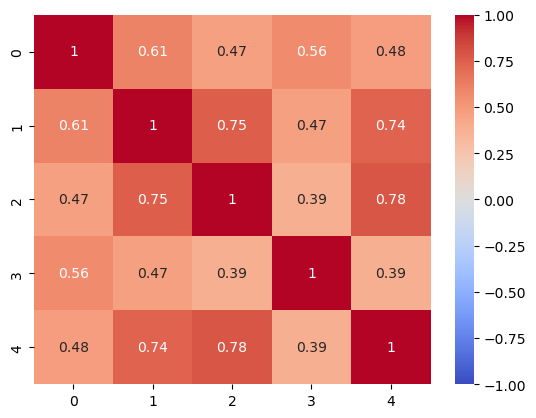

In [23]:
sns.heatmap(
    data = pd.DataFrame(
    np.column_stack((
        ada_best.predict(X_train),
        hgbc_best.predict(X_train), 
        rf_best.predict(X_train), 
        lr_best.predict(X_train), 
        knn_best.predict(X_train),
        )),
    # columns = model_performance['model_list']
    ).corr(),
    annot = True,
    cmap = 'Blues',
    vmin = -1,
    vmax = 1
)

In [24]:
# check coefficents from LogisticRegression
# feature_names = lr_best[0].get_feature_names_out()
# coefficients = lr_best[2].coef_
# features_coefs = pd.DataFrame([feature_names, coefficients.reshape(52,)]).transpose()
# features_coefs.rename(columns={0: 'feature', 1: 'coef'}, inplace=True)
# features_coefs.sort_values(by='coef', ascending=False)

In [25]:
# create VotingClassifier ensemble with top performing classifiers and new params
# voting_clf = VotingClassifier([
#     ('GradientBoost', GradientBoostingClassifier(n_estimators=300, random_state=rng)),
#     ('AdaBoost', AdaBoostClassifier(n_estimators=200, random_state=rng)),
#     ('RandomForest', RandomForestClassifier(n_estimators=700, max_features='sqrt', random_state=rng))
# ], voting='soft')

# voting_params = {
#     'sample__sampling_strategy': ['auto', 0.1, 0.3],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
# }

In [29]:
# create VotingClassifier ensemble with best performing classifiers
voting_clf = VotingClassifier([
    # ('HistGradientBoost', hgbc_best[-1]),
    ('AdaBoost', ada_best[-1]),
    ('LogReg', lr_best[-1]),
    # ('RandomForest', rf_best[-1])
], voting='soft')

voting_params = {
    'sample__sampling_strategy': ['auto', 0.1, 0.25, 0.5],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
}

In [30]:
voting_best, voting_results = results.run_pipe(voting_clf, voting_params)

Fitting VotingClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Elapsed time: 1 minutes, 25 seconds
Best Score:  0.25065864503645613
Best Params:  {'sample__sampling_strategy': 0.25}



In [31]:
results.display()

,model_list,mean_train_f1,mean_test_f1,f1_delta,mean_train_balanced_accuracy,mean_test_balanced_accuracy,balanced_accuracy_delta,best_params,runtime
4,HistGradientBoostingClassifier,0.2759,0.1832,0.0927,0.6463,0.5729,0.0734,"{'clf__l2_regularization': 1, 'clf__learning_r...",95.62
2,RandomForestClassifier,0.2481,0.1696,0.0785,0.6129,0.5619,0.0509,"{'clf__ccp_alpha': 0.0, 'clf__max_features': '...",599.59
5,VotingClassifier,0.2479,0.1960,0.0519,0.7560,0.6657,0.0903,{'sample__sampling_strategy': 0.25},85.19
0,LogisticRegression,0.2432,0.2012,0.0420,0.7532,0.6795,0.0738,"{'clf__C': 1.0, 'clf__max_iter': 100, 'clf__pe...",31.45
3,AdaBoostClassifier,0.2342,0.2052,0.0289,0.6548,0.6062,0.0487,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",133.13
1,KNeighborsClassifier,0.2262,0.1996,0.0266,0.6714,0.6604,0.0110,"{'clf__n_neighbors': 15, 'clf__weights': 'dist...",8.32


Selecting the top performing model based on `balanced accuracy` score.

In [32]:
best_model = hgbc_best

## Model Performance

---

Random text

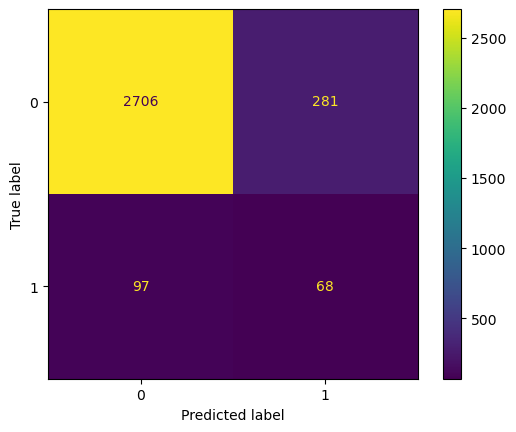

In [33]:
preds = best_model.predict(X_test)
cm_disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2987
           1       0.22      0.46      0.30       165

    accuracy                           0.88      3152
   macro avg       0.59      0.68      0.62      3152
weighted avg       0.93      0.88      0.90      3152



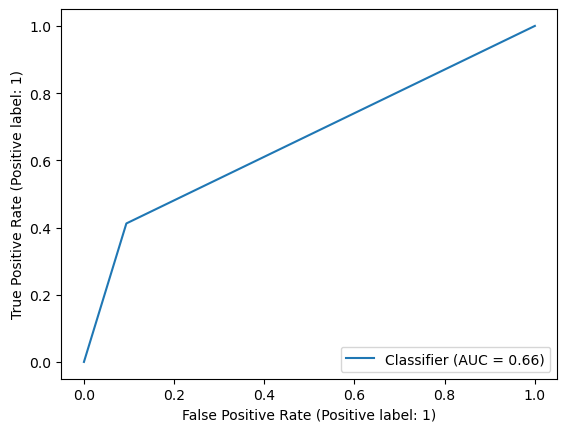

In [34]:
RocCurveDisplay.from_predictions(y_test, preds);

In [70]:
threshold = []
accuracy = []

for p in np.linspace(0,1,101):
  threshold.append(p)
  y_pred = (best_model.predict_proba(X)[:,1] >= p).astype(int)
  accuracy.append(f1_score(y,y_pred))

threshold_max = threshold[np.argmax(accuracy)]

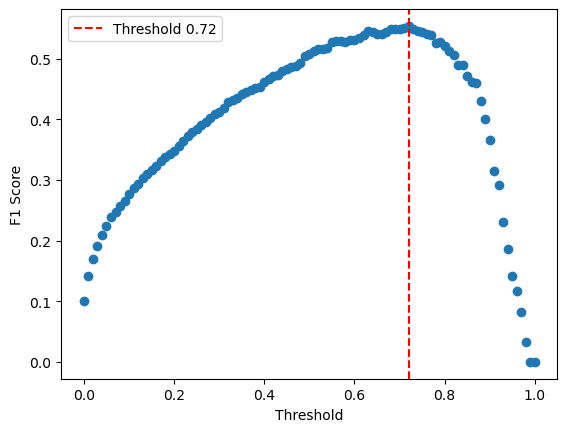

In [85]:
plt.scatter(threshold,accuracy)
plt.axvline(x=threshold_max, linestyle='--', c='red', label=f'Threshold {threshold_max}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

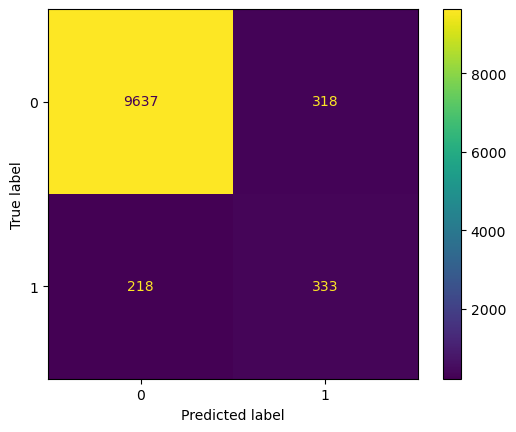

In [86]:
y_hat = pd.Series(np.where(best_model.predict_proba(X)[:,1] >= threshold_max, 1, 0), 
                     dtype='category')
cm_disp_yhat = ConfusionMatrixDisplay.from_predictions(y, y_hat)

In [73]:
print(classification_report(y, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      9955
           1       0.51      0.60      0.55       551

    accuracy                           0.95     10506
   macro avg       0.74      0.79      0.76     10506
weighted avg       0.95      0.95      0.95     10506



In [ ]:
# best_model.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['Latitude', 'Longitude',
                                                   'AddressAccuracy', 'Tavg',
                                                   'Depart', 'Heat',
                                                   'PrecipTotal', 'SeaLevel',
                                                   'ResultDir', 'AvgSpeed',
                                                   'Humidity', 'Daylight_hours',
                                                   'Sunrise', 'Sunset']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if...
                                               HistGradientBoostingClassifier(l2_regularization=1,
                                                                              learning_rate=0.01,
                                                                              random_state=42)),
                                              ('AdaBoost',
                                               AdaBoostClassifier(n_estimators=150,
                                                                  random_state=42)),
                                              ('LogReg',
                                               LogisticRegression(C=10,
                                                                  class_weight='balanced',
                                                                  random_state=42,
                                                                  solver='liblinear')),
                                              ('RandomForest',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      n_estimators=500,
                                                                      random_state=42))],
                                  voting='soft'))])

## Predictions

---

Prediction with `test.csv`.

In [74]:
df_test = pd.read_csv('../assets/df_merge_test.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [75]:
df_test = create_dt_features(df_test)

In [76]:
df_test[features]

,Latitude,Longitude,AddressAccuracy,Tavg,Depart,Heat,PrecipTotal,SeaLevel,ResultDir,AvgSpeed,Humidity,Daylight_hours,Sunrise,Sunset,Species,Trap,Month,Day,CodeSum
0,41.95,-87.80,9,74.0,7.0,0.0,0.00,29.99,18,10.0,53.41,15.17,4.27,19.43,CULEX PIPIENS/RESTUANS,002,6,11,Clear
1,41.95,-87.80,9,74.0,7.0,0.0,0.00,29.99,18,10.0,53.41,15.17,4.27,19.43,CULEX RESTUANS,002,6,11,Clear
2,41.95,-87.80,9,74.0,7.0,0.0,0.00,29.99,18,10.0,53.41,15.17,4.27,19.43,CULEX PIPIENS,002,6,11,Clear
3,41.95,-87.80,9,74.0,7.0,0.0,0.00,29.99,18,10.0,53.41,15.17,4.27,19.43,CULEX SALINARIUS,002,6,11,Clear
4,41.95,-87.80,9,74.0,7.0,0.0,0.00,29.99,18,10.0,53.41,15.17,4.27,19.43,CULEX TERRITANS,002,6,11,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,41.72,-87.67,9,71.0,13.0,0.0,0.72,29.78,17,7.9,75.86,11.72,5.82,17.53,CULEX SALINARIUS,094,10,2,TSRA RA BR
116289,41.72,-87.67,9,71.0,13.0,0.0,0.72,29.78,17,7.9,75.86,11.72,5.82,17.53,CULEX TERRITANS,094,10,2,TSRA RA BR
116290,41.72,-87.67,9,71.0,13.0,0.0,0.72,29.78,17,7.9,75.86,11.72,5.82,17.53,CULEX TARSALIS,094,10,2,TSRA RA BR
116291,41.72,-87.67,9,71.0,13.0,0.0,0.72,29.78,17,7.9,75.86,11.72,5.82,17.53,UNSPECIFIED CULEX,094,10,2,TSRA RA BR


In [77]:
# results = best_model.predict(df_test[features])

# results = ada_best.predict(df_test[features])

results = pd.Series(np.where(best_model.predict_proba(df_test[features])[:,1] >= threshold_max, 1, 0), 
                     dtype='category')

In [78]:
def create_predictions(predictions, filename):
    if not os.path.isdir('../output'):
        os.mkdir('../output')
    
    if not os.path.isfile(f'../output/{filename}.csv'):
        results_df = pd.DataFrame(predictions)
        results_df.insert(0, column='id', value=range(1, len(predictions)+1))
        results_df.to_csv(f"../output/{filename}.csv", header=["Id", "WnvPresent"], index=False)
    else:
        raise NameError(f'{filename}.csv already exists!')

In [80]:
output_filename = 'predictions_20'

create_predictions(results, output_filename)

In [81]:
results.display() #.to_csv(f'../output/params_{output_filename}.csv', index=False)

AttributeError: 'Series' object has no attribute 'display'